## Исследовательский анализ данных Яндекс.Недвижимости
Мне были предоставлены данные за 2014-2019 года о продажах квартир в Санкт-Петербурге и ЛО на Яндекс.Недвижимости. Также внутри базы содержится информация о параметрах продажи (сколько комнат, площадь, информация об инфраструктуре и т.д.). Задача найти зависимости и выявить некоторые закономерности и гипотезы, что в дальнейшем поможет при оптимизации сервиса и улучшения ее для пользователей.

Прежде чем начинать исследование, стоит изучить и обработать датафрейм на предмет пропусков, дубликатов и аномалий, чтобы в будущем полученные выводы были достоверны. После этого приступим к исследованию таких моментов как:
- Парамтеры объектов
- Скорость продажи квартиры
- Факторы, влияющие на ценообразование, а также как именно населенный пункт влияет на стоимость одного квадратного метра квартиры
- Стоимость одного километра в зависимости от близости центра

После проведения анализа будет дан общий вывод, описывающий всю проделанную работу

In [1]:
import pandas as pd
import matplotlib as mtb
import numpy as np
import re
import matplotlib.pyplot as plt
pd.options.display.float_format ='{:.2f}'.format
pd.set_option('max_colwidth', 9120)
pd.set_option('display.width', 9500)

## Шаг 1

In [2]:
try: data = pd.read_cvs('real_estate_data.csv', sep='\t')
except: data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
    

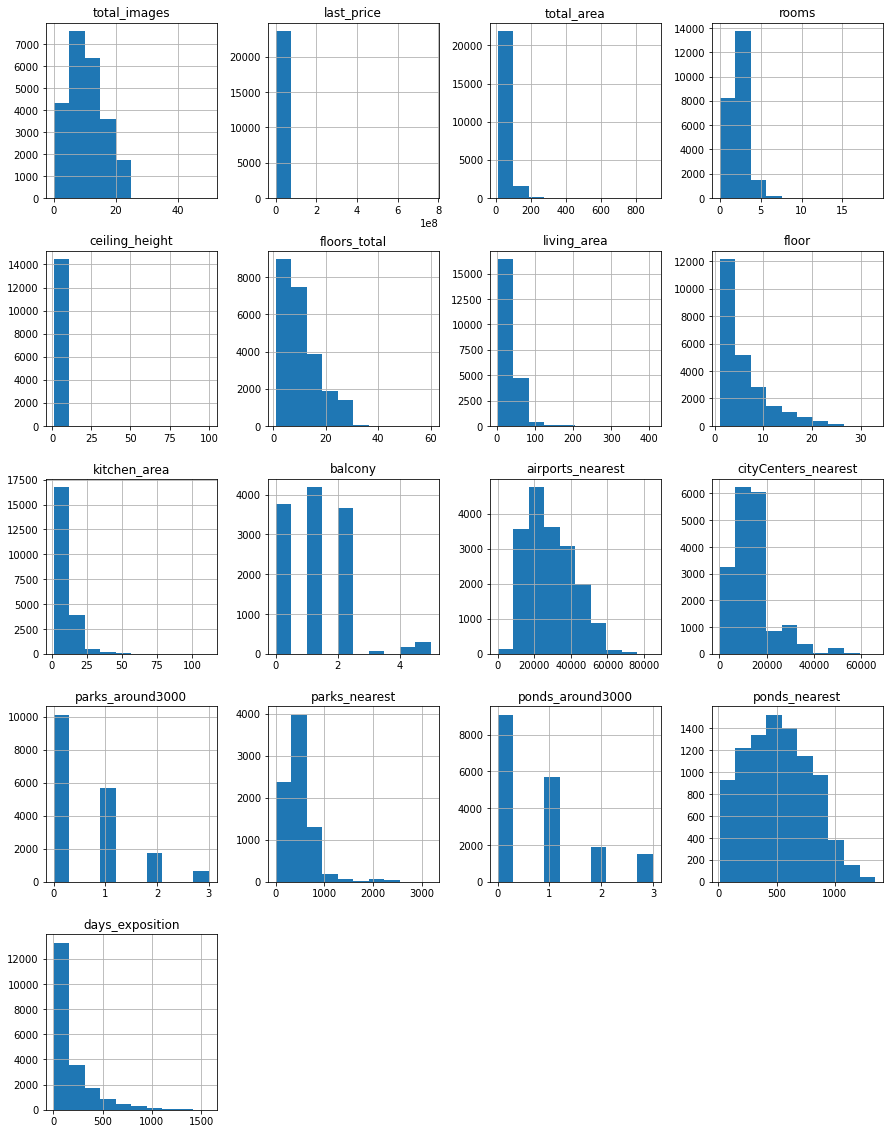

In [3]:
data.hist(figsize = (15,20));

## Шаг 2

#### 1.Найдите и изучите пропущенные значения в столбцах:

In [4]:
data.isna().sum().sort_values()

total_images                0
open_plan                   0
floor                       0
rooms                       0
studio                      0
total_area                  0
last_price                  0
first_day_exposition        0
locality_name              49
floors_total               86
living_area              1903
kitchen_area             2278
days_exposition          3181
ponds_around3000         5518
parks_around3000         5518
cityCenters_nearest      5519
airports_nearest         5542
ceiling_height           9195
balcony                 11519
ponds_nearest           14589
parks_nearest           15620
is_apartment            20924
dtype: int64

Начнем устранять пропуски в столбцах по мере увеличения их количества. Начнем с колонки locality_name - информация о названии населенного пункта. Причины пропусков может быть следущими:
1. Название населеного пункта отсуствует на сайте
2. Продавец мог забыть внести информацию
3. Также причина может быть в том что населенного пункта еще не существует и объект находится только на этапе стротельства. В данном случае объекту принадлежит только строительный адрес, который не фиксируется на карте и объекту еще не был причислен милицейский адрес
4. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко

В данном случае заполним пропуски словом "Неизвестно"

In [5]:
data['locality_name'] = data['locality_name'].fillna('Неизвестно')

floors_total - всего этажей в доме. Причины пропусков могут быть следующими:
1. Дом еще не построен
2. Продавец мог не указать информацию
В данном случае сложно предположить типовое количество этажей, которое можно поставить вместо пропусков (поскольку 0 этажей, например, не существуют). Поэтому оставим пропуски, тем более что в общем количестве строк их количество крайне мало

living_area - жилая площадь в квадратных метрах. Причины пропусков могут быть следующими:
1. Продавец может не знать площадь объекта
2. Продавец забыл внести информацию
3. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко

Логично заполнить пропуски из среднего метража квартир с тем же количеством комнат

In [6]:
mean_area = data.groupby('rooms')['living_area'].mean().to_frame().reset_index()
data.loc[data['living_area'].isna(), 'living_area'] =  data.loc[data['living_area'].isna(),'rooms'].apply(lambda x: mean_area.loc[x,'living_area'] )

mean_area

,rooms,living_area
0,0,18.87
1,1,17.89
2,2,31.74
3,3,47.39
4,4,66.98
5,5,100.01
6,6,130.98
7,7,163.56
8,8,168.68
9,9,190.26


kitchen_area - площадь кухни. Причины пропусков могут быть следующими:
1. В случае когда площадь кухни совмещена с гостинной/всей квартирой
2. Продавец мог забыть или не знать информацию и не внести ее
3. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко

Логично заполнить пропуски из среднего метража кухонь с тем же количеством комнат

In [7]:
mean_kitchen = data.groupby('rooms')['kitchen_area'].mean().to_frame().reset_index()
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] =  data.loc[data['kitchen_area'].isna(),'rooms'].apply(lambda x: mean_kitchen.loc[x,'kitchen_area'] )


In [8]:
data['kitchen_area'].isnull().sum()

197

In [9]:
mean_kitchen

,rooms,kitchen_area
0,0,NaN
1,1,9.55
2,2,9.98
3,3,11.31
4,4,13.66
5,5,18.37
6,6,21.05
7,7,22.00
8,8,24.87
9,9,25.07


Однако после подстановки было выявлено, что в датафрейме отсутствует какая-либо информация о площадях кухонь в квартирах с нулевым количеством комнат. Это может быть связано как с тем, что речь идет о студиях в которой как таковой площади кухни нет, поскольку разделения на комнаты нет и поэтому выделить кухню сложно. Поэтому оставим пропуски и не будем ставить 0, чтобы не повлиять на общее среднее/медиану площадей кухонь

days_exposition - сколько дней было размещено объявление (от публикации до снятия). Причины пропусков (варианты при которых информация не пришла в базу не рассматривается в виду тревиальности):
1. Объявление еще не было закрыто (удалено, отозвано)
2. Продавец мог забыть закрыть объявление, даже если оно потеряло свою актуальность
В качестве заполнения пропусков выберем медиану, т.к. присутствуют выбросы (максимальное значение 1580 при среднем 180. Большое среднеквадратичное отклонение равное 219,73) 

In [10]:
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

ponds_around3000 — число водоёмов в радиусе 3 км. Причины пропусков:
1. Водоемы отсутствуют в радиусе 3км
2. Продавец не забыл внести информацию
3. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко

В данном случае логичным было бы вставить вместо пропусков число 0

In [11]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

parks_around3000 — число парков в радиусе 3 км. Причины пропусков:
1. Парки отсутствуют в радиусе 3км
2. Продавец не забыл внести информацию
3. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко

В данном случае логичным было бы вставить вместо пропусков число 0

In [12]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)

cityCenters_nearest — расстояние до центра города (м). Причины пропусков:
1. Квартира находится в поселке
2. Квартира находится на большом расстоянии от центра города, а на сайте ограничения по вводу данных. И поэтому продавец не внес информацию
3. Продавец мог забыть внести данные
4. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко

Логично заполнить пропуски из среднего расстояния до центра города, исходя из населенного пункта. Там где это будет невозможно, оставим значения пустыми

In [13]:
mean_centers_nearest = data.groupby('locality_name')['cityCenters_nearest'].mean().to_frame()
data.loc[data['cityCenters_nearest'].isna(), 'cityCenters_nearest'] =  data.loc[data['cityCenters_nearest'].isna(),'locality_name'].apply(lambda x: mean_centers_nearest.loc[x,'cityCenters_nearest'] )


airports_nearest - расстояние до ближайшего аэропорта в метрах (м). Причины пропусков:
1. Квартира находится в поселке и аэропорт не находится в населенном пункте
2. Квартира находится на большом расстоянии от ближайшего аэропорта, а на сайте ограничения по вводу данных. И поэтому продавец не внес информацию
3. Продавец мог забыть внести данные
4. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко

Логично заполнить пропуски из среднего расстояния до ближайшего аэропорта, исходя из населенного пункта. Там где это будет невозможно, оставим значения пустыми

In [14]:
mean_airports_nearest = data.groupby('locality_name')['airports_nearest'].mean().to_frame()
data.loc[data['airports_nearest'].isna(), 'airports_nearest'] =  data.loc[data['airports_nearest'].isna(),'locality_name'].apply(lambda x: mean_airports_nearest.loc[x,'airports_nearest'] )


ceiling_height — высота потолков (м). Причины пропусков:
1. Продавец мог забыть внести данные
2. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко
3. Продавец может не знать высоту потолков
4. Идет стройка и точная информация об итоговой высоте неизвестна

Заполним пропуски медианой, поскольку явно присутствуют нереалистичные выбросы (это видно по максимуму равному 100 метров). Дополнительная разбивка не требуется, т.к. нет большого разброса значений по выборке

In [15]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

balcony — число балконов. Причины пропусков:
1. Балкона нет на объекте
2. Продавец мог не знать информацию
3. Продавец забыл внести информацию
4. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко

В качестве заполнения пропусков было выбрано проставить 0, чтобы показать возможное отсутствие балконов

In [16]:
data['balcony'] = data['ponds_around3000'].fillna(0)

ponds_nearest — расстояние до ближайшего водоёма (м). Причины пропусков:
1. Квартира находится на большом расстоянии от ближайшего водоема, а на сайте ограничения по вводу данных. И поэтому продавец не внес информацию
2. Продавец мог забыть внести данные
3. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко
4. Водоемов рядом просто нет
5. Продавец не знает о расстоянии до ближайшего водоема

Логично заполнить пропуски из среднего расстояния до ближайшего водоема, исходя из населенного пункта. Там где это будет невозможно, оставим значения пустыми

In [17]:
mean_ponds_nearest = data.groupby('locality_name')['ponds_nearest'].mean().to_frame()
data.loc[data['ponds_nearest'].isna(), 'ponds_nearest'] =  data.loc[data['ponds_nearest'].isna(),'locality_name'].apply(lambda x: mean_ponds_nearest.loc[x,'ponds_nearest'] )


parks_nearest — расстояние до ближайшего парка (м)
1. Квартира находится на большом расстоянии от ближайшего парка, а на сайте ограничения по вводу данных. И поэтому продавец не внес информацию
2. Продавец мог забыть внести данные
3. В случае когда продавец продает не конкретно квартиру, а делает рекламу жк или просто привлекает клиентов, а как таковой квартиры обычно нет. И в таких случаях уточняющие параметры вносятся редко
4. Парков рядом просто нет
5. Продавец не знает о расстоянии до ближайшего парка

Логично заполнить пропуски из среднего расстояния до ближайшего парка, исходя из населенного пункта. Там где это будет невозможно, оставим значения пустыми

In [18]:
mean_parks_nearest = data.groupby('locality_name')['parks_nearest'].mean().to_frame()
data.loc[data['parks_nearest'].isna(), 'parks_nearest'] =  data.loc[data['parks_nearest'].isna(),'locality_name'].apply(lambda x: mean_parks_nearest.loc[x,'parks_nearest'] )


is_apartment — апартаменты (булев тип). Причины пропусков:
1. Скорее всего апартаментом не является
2. Продавец мог не указать данную информацию специально, поскольку апартаменты менее привлекательный тип жилья
3. Продавец мог забыть указать этот параметр

Заполним пропуски 'False', т.к. достоверно мы не знаем является ли объект апартаментом. 

In [19]:
data['is_apartment'] = data['is_apartment'].fillna(False)

После обработки данных получили следующее количество пропусков:

In [20]:
data.isna().sum().sort_values()

total_images               0
ponds_around3000           0
parks_around3000           0
locality_name              0
balcony                    0
open_plan                  0
is_apartment               0
floor                      0
studio                     0
ceiling_height             0
rooms                      0
first_day_exposition       0
total_area                 0
last_price                 0
living_area                0
days_exposition            0
floors_total              86
kitchen_area             197
airports_nearest        5386
cityCenters_nearest     5386
ponds_nearest           5494
parks_nearest           5998
dtype: int64

#### 2. Рассмотрите типы данных в каждом столбце:
- Найдите столбцы, в которых нужно изменить тип данных.
- Преобразуйте тип данных в выбранных столбцах.
- В ячейке с типом markdown поясните, почему нужно изменить тип данных.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23502 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

Изучив тип данных датафрейма и смысл каждой колонки, было принято решение изменить тип данных у следующих колонок:
- first_day_exposition - дата публикации. В изначальной версии датафрейма эта колонка имела тип object. Но по смыслу это была дата, поэтому было принято решение сменить тип данных на datetime64, убрав разделитель "Т"

In [22]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

- floors_total - число этажей в доме. По смыслу эта колонка должна быть целочисленной (поскольку не существует, например, 3,5 этажа)

In [23]:
data['floors_total'] = data['floors_total'].round().astype('Int64')

- В случае с balcony, parks_around3000, ponds_around3000 ситуация аналогична как с floors_total

In [24]:
data['balcony'] = data['balcony'].astype('Int64')
data['parks_around3000'] = data['parks_around3000'].astype('Int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('Int64')

- days_exposition - сколько дней было размещено объявление (от публикации до снятия). В результате изучения датафрейма было замечено что данные в этой колонке указаны только с целой частью и без дробной. На основе этого было принято решение сменить тип данных на int

In [25]:
data['days_exposition'] = data['days_exposition'].round().astype('Int64')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  Int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23502 non-null  float64       
 13  balcony         

#### 3. Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты. Например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов. Вы можете заменить названия в существующем столбце или создать новый с названиями без дубликатов.

In [27]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [28]:
data['locality_name'] = data['locality_name'].apply(lambda x: x.lower())
data['locality_name'] = data['locality_name'].apply(lambda x: re.sub('посёлок', 'поселок', x))
for word in ['поселок', 'деревня','городской поселок','садовое товарищество','коттеджный поселок','городского типа', 'городской','коттеджный', 'имени','село','станции','пансионат','при железнодорожной',r'^ *']:
    data['locality_name'] = data['locality_name'].apply(lambda x: re.sub(word,'', x))


In [29]:
data['locality_name'].unique()

array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красный бор', 'гатчина', 'фёдоровское',
       'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное ', 'понтонный', 'сясьстрой',
       'старая', 'лесколово', 'новый свет', 'сланцы', 'путилово',
       'ивангород', 'шлиссельбург', 'никольское', 'зеленогорск',
       'сосновый бор', 'оржицы', 'кальтино', 'романовка', 'бугры',
       'рощино', 'кириши', 'луга', 'волосово', 'отрадное', 'павлово',
       'оредеж', 'копорье', 'молодёжное', 'тихвин', 'победа', 'нурма',
       'синявино', 'тосно', 'стрельна', 'бокситогорск', 'ал

#### 4. Найдите и устраните редкие и выбивающиеся значения. Например, в столбце ceiling_height может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м. Попробуйте обработать аномалии в этом и других столбцах.
- Если природа аномалии понятна и данные действительно искажены, то восстановите корректное значение.
- В противном случае удалите редкие и выбивающиеся значения.
- В ячейке с типом markdown опишите, какие особенности в данных вы обнаружили.

In [30]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.00,23699.00,23699.00,23699.00,23699.00,23613.00,23699.00,23699.00,23502.00,23699.00,18313.00,18313.00,23699.00,17701.00,23699.00,18205.00,23699.00
mean,9.86,6541548.77,60.35,2.07,2.72,10.67,34.44,5.89,10.57,0.59,28867.93,14228.33,0.47,492.20,0.59,519.31,169.36
std,5.68,10887013.27,35.65,1.08,0.99,6.60,21.80,4.89,5.67,0.88,12670.68,8624.86,0.75,231.90,0.88,197.93,206.54
min,0.00,12190.00,12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3400000.00,40.00,1.00,2.60,5.00,18.40,2.00,7.30,0.00,18641.00,9274.00,0.00,447.00,0.00,477.00,45.00
50%,9.00,4650000.00,52.00,2.00,2.65,9.00,30.30,4.00,9.55,0.00,26832.00,13095.00,0.00,498.60,0.00,520.21,95.00
75%,14.00,6800000.00,69.90,3.00,2.70,16.00,42.70,8.00,11.60,1.00,37313.00,16319.00,1.00,498.60,1.00,561.00,199.00
max,50.00,763000000.00,900.00,19.00,100.00,60.00,409.70,33.00,112.00,3.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


Аномалии были замечены в следующих колонках (в случае, когда были замечены необъяснимые аномалии были использованы замены, чтобы не порождать лишние пропуски, если это будет возможно):
- rooms - число комнат. Не бывает число комнат равные 0. Возможно это студии и продавец мог не указать это, поскольку студия не является n-комнатной квартирой, но комната у нее по сути есть и она одна. Поэтому заменим 0 на 1

In [31]:
data.loc[data['rooms']==0,'rooms']=1

- ceiling_height - высота потолков. В случае когда в данных показатели больше 20 может быть  что это вещественные числа и их нужно делить на 10, чтобы перевести в метры. В случаях, когда высота квартиры меньше 2.4 метров (считается минимумом в России, было выяснено из открытых источников), таких квартир не существует. Природа данной аномалии не ясна. Поэтому вместо удаления этих показателей, заменим их медианой как в случае с пропусками в задании выше. Остается один случай. когда высота потолка равна 14. Этот показатель принадлежал двухкомнатной квартире из метражом 56кв.м.. Даже при условии что квартира может быть двухэтажной, данную высоту достичь невозможно. Поэтому также заменим этот показатель на медиану

In [32]:
data['ceiling_height'] = np.where(((data['ceiling_height']>=20.0) & (data['ceiling_height']<=100.0)), data['ceiling_height']/10, \
                                 np.where(((data['ceiling_height']<2.4) | (data['ceiling_height']==14.0)), data['ceiling_height'].median(), data['ceiling_height']))

- living_area - жилая площадь в квадратных метрах. Было замечено, что жилая площадь может достигать до 2, 3 или 5 квадратных метров для квартир с 1-4 комнатами с площадями от 23 до 139 квадратных метров, что является аномалией. В данном случае заменим эти показатели на средние свойственные для данного количества комнат

In [33]:
data['living_area'] = np.where((data['rooms']==1) & (data['living_area']<=8.0), 17.92,
                        np.where(((data['rooms']==2) & (data['living_area']<=8.0)), 31.74,
                        np.where(((data['rooms']==3) & (data['living_area']<=8.0)), 47.39, \
                                np.where(((data['rooms']==4) & (data['living_area']<=8.0)),66.98,  data['living_area']))))

- kitchen_area - площадь кухни в квадратных метрах. Изучив нормативы и предоставленые данные было выявлено, что кухни меньшей площади чем 5 метров являются аномалией. Природа аномалии не ясна, поэтому заменим показатели меньшие 5 квадратных метров на средние, которые были высчитаны в предыдущих заданиях

In [34]:
data.loc[data['kitchen_area']<5.0, 'kitchen_area'] =  data.loc[data['kitchen_area']<5.0,'rooms'].apply(lambda x: mean_kitchen.loc[x,'kitchen_area'])

- airports_nearest - расстояние до ближайшего аэропорта. В минимуме было замечено, что показатель равен 0. Такого быть не может. Поэтому просто удалим этот показатель

In [35]:
data.loc[data['airports_nearest']==0, 'airports_nearest'] = None

- parks_nearest - расстояние до ближайшего парка. В столбце указаны значения, которые меньше 25 метров. Странно себе представить, чтобы парк находился ближе. Поскольку таких значений достаточно много, заменим их на средние для показетелей населенного пункта

In [36]:
mean_parks_nearest = data.groupby('locality_name')['parks_nearest'].mean().to_frame()
data.loc[data['parks_nearest']<=25.0, 'parks_nearest'] =  data.loc[data['parks_nearest']<=25.0,'locality_name'].apply(lambda x: mean_parks_nearest.loc[x,'parks_nearest'] )

In [37]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.00,23699.00,23699.00,23699.00,23699.00,23613.00,23699.00,23699.00,23502.00,23699.00,18312.00,18313.00,23699.00,17701.00,23699.00,18205.00,23699.00
mean,9.86,6541548.77,60.35,2.08,2.70,10.67,34.45,5.89,10.59,0.59,28869.51,14228.33,0.47,494.68,0.59,519.31,169.36
std,5.68,10887013.27,35.65,1.07,0.24,6.60,21.80,4.89,5.65,0.88,12669.23,8624.86,0.75,229.29,0.88,197.93,206.54
min,0.00,12190.00,12.00,1.00,2.00,1.00,8.30,1.00,5.00,0.00,6450.00,181.00,0.00,27.00,0.00,13.00,1.00
25%,6.00,3400000.00,40.00,1.00,2.60,5.00,18.40,2.00,7.40,0.00,18641.00,9274.00,0.00,454.00,0.00,477.00,45.00
50%,9.00,4650000.00,52.00,2.00,2.65,9.00,30.30,4.00,9.55,0.00,26833.50,13095.00,0.00,498.60,0.00,520.21,95.00
75%,14.00,6800000.00,69.90,3.00,2.70,16.00,42.70,8.00,11.60,1.00,37313.00,16319.00,1.00,498.60,1.00,561.00,199.00
max,50.00,763000000.00,900.00,19.00,10.30,60.00,409.70,33.00,112.00,3.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


Проверим выборку на наличие явных дубликатов:

In [38]:
data.duplicated().unique()

array([False])

Явные дубликаты отсутствуют

Итак, после обработки аномалий можно сделать следующие выводы. В основном аномалии были выявлены при помощи простой описательной функции датафрейма, что позволило выявить такие несуществующие показатели как, например, высота потолка в 1 метр или же 0 комнат в квартире

## Шаг 3. Добавьте в таблицу новые столбцы со следующими параметрами:
- цена одного квадратного метра;

In [39]:
data['one_square_meter'] = (data['last_price']/data['living_area']).astype('float64')

- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);

In [40]:
data['day_of_week_published'] = data['first_day_exposition'].dt.weekday

- месяц публикации объявления;

In [41]:
data['month_published'] = data['first_day_exposition'].dt.month

- год публикации объявления;

In [42]:
data['year_published'] = data['first_day_exposition'].dt.year

- тип этажа квартиры (значения — «‎первый», «последний», «другой»);

In [43]:
data.loc[data['floors_total'].isna()==False,'type_floor'] = np.where(data[data['floors_total'].isna()==False]['floor']==1 , 'Первый', np.where(data[data['floors_total'].isna()==False]['floor']==data[data['floors_total'].isna()==False]['floors_total'], 'Последний', 'Другой'))

- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [44]:
data['distance_in_km'] = (data['cityCenters_nearest']/1000).round()
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_square_meter,day_of_week_published,month_published,year_published,type_floor,distance_in_km
0,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,482.00,2,755.00,95,254901.96,3,3,2019,Другой,16.00
1,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,False,...,NaN,0,573.22,81,180107.53,1,12,2018,Первый,19.00
2,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,False,...,90.00,2,574.00,558,151486.88,3,8,2015,Другой,14.00
3,0,64900000.00,159.00,2015-07-24,3,2.65,14,47.39,9,False,...,84.00,3,234.00,424,1369546.75,4,7,2015,Другой,7.00
4,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,112.00,1,48.00,121,312500.00,1,6,2018,Другой,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.00,133.81,2017-03-21,3,3.70,5,73.30,3,False,...,796.00,3,381.00,95,132332.88,1,3,2017,Другой,4.00
23695,14,3100000.00,59.00,2018-01-15,3,2.65,5,38.00,4,False,...,NaN,0,NaN,45,81578.95,0,1,2018,Другой,NaN
23696,18,2500000.00,56.70,2018-02-11,2,2.65,3,29.70,1,False,...,NaN,0,NaN,95,84175.08,6,2,2018,Первый,NaN
23697,13,11475000.00,76.75,2017-03-28,2,3.00,17,31.74,12,False,...,173.00,3,196.00,602,361567.08,1,3,2017,Другой,10.00


## Шаг 4.1 Проведите исследовательский анализ данных:
Изучите следующие параметры объектов:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

In [45]:
from datetime import datetime
data['day_exposition'] = data['first_day_exposition'].apply(lambda x: x.strftime('%d')).astype(int)


In [46]:
columns= ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height', 'floor', 'floors_total', 'type_floor', 'cityCenters_nearest', 'airports_nearest', 'parks_nearest','day_exposition','month_published']



In [47]:
, xticks=range(int(data[column].min()),int(data[column].max()),int(data[column].max()/10

'xticks=range(int(data[column].min()),int(data[column].max()),int(data[column].max()/10'

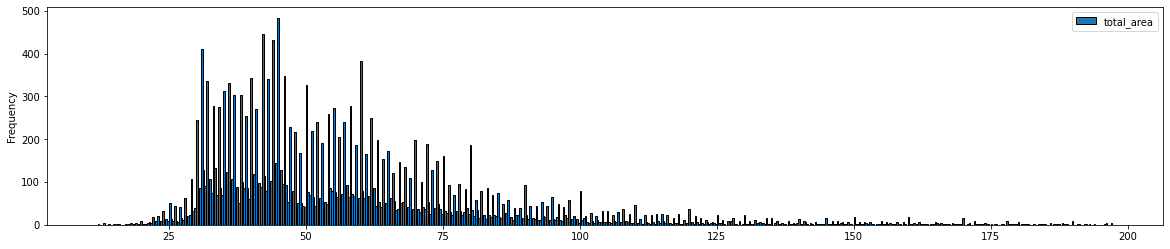

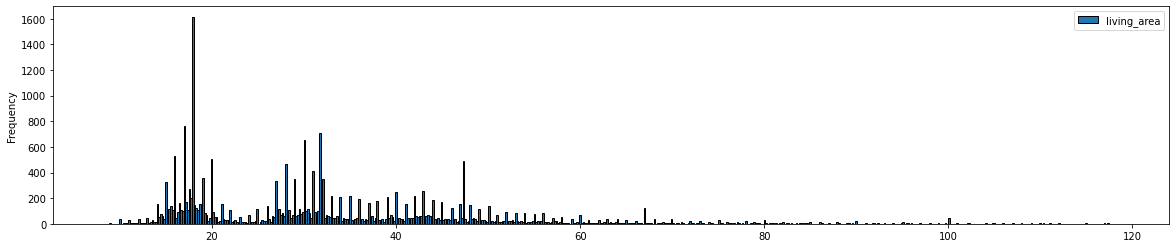

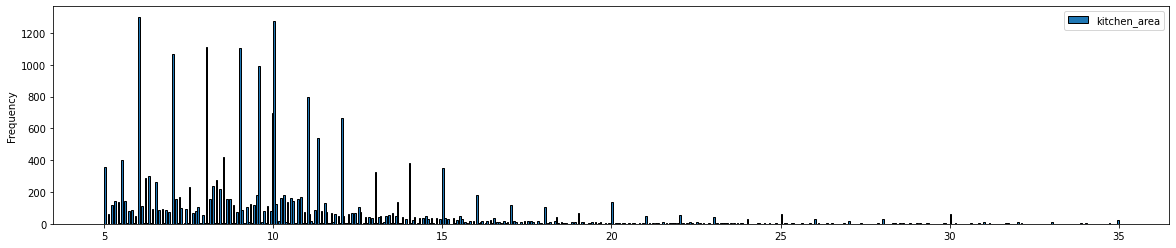

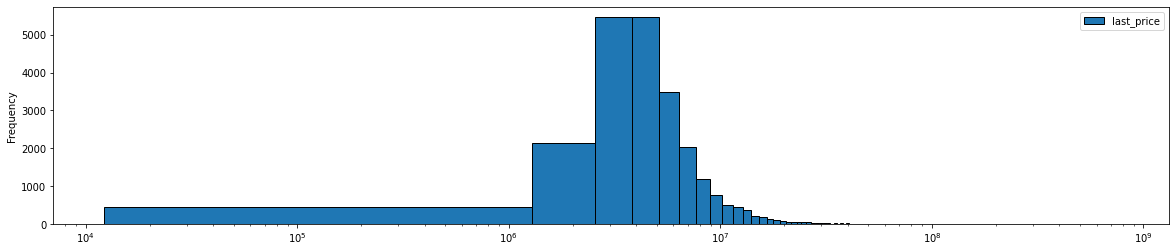

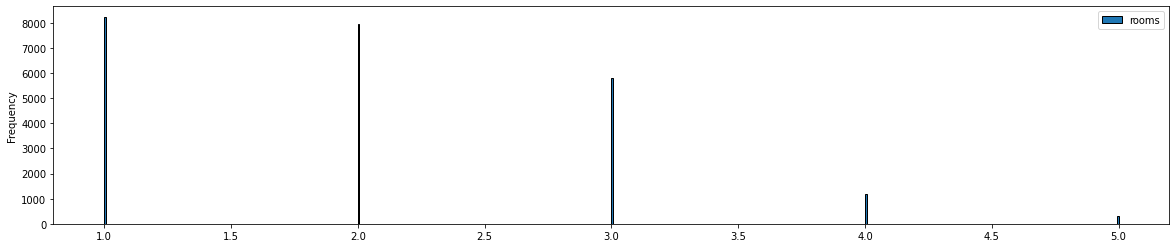

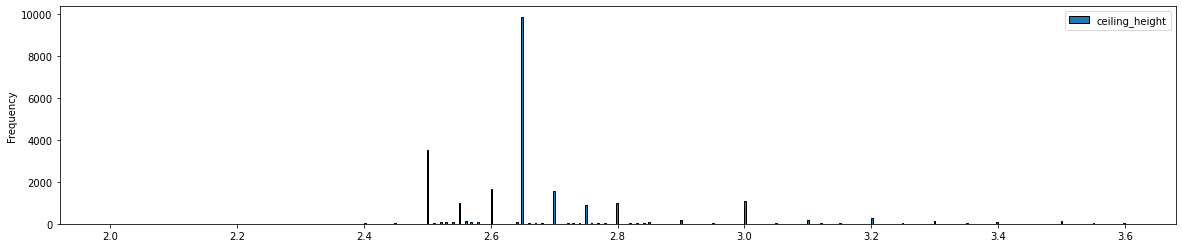

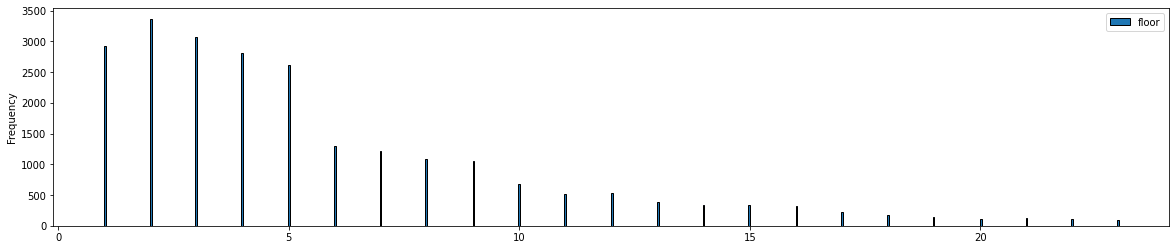

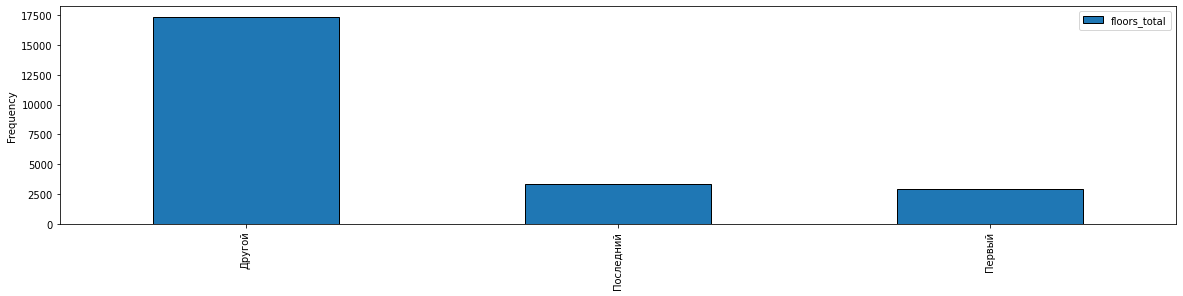

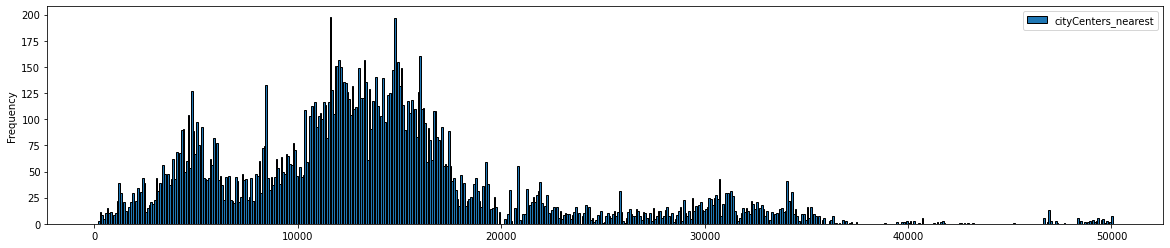

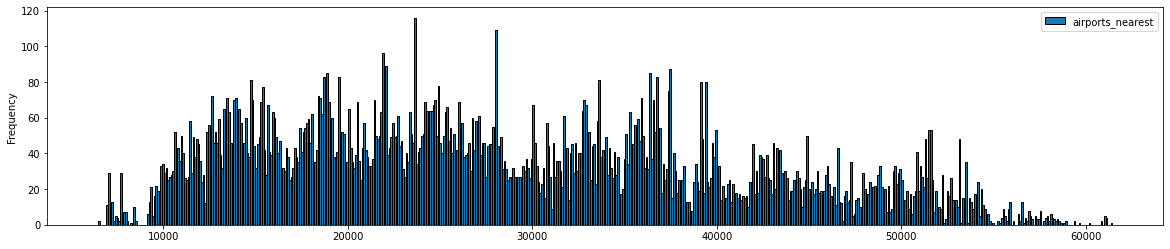

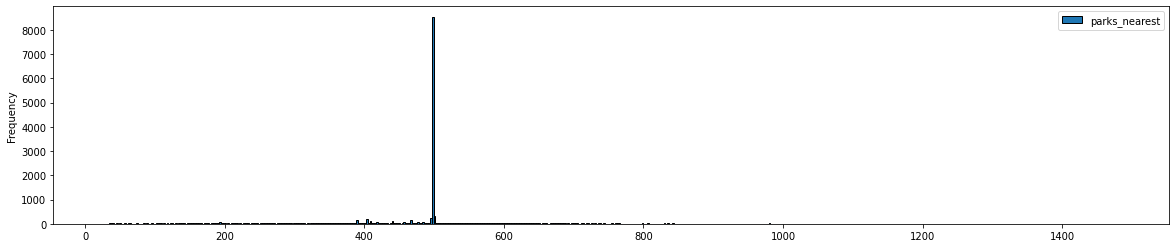

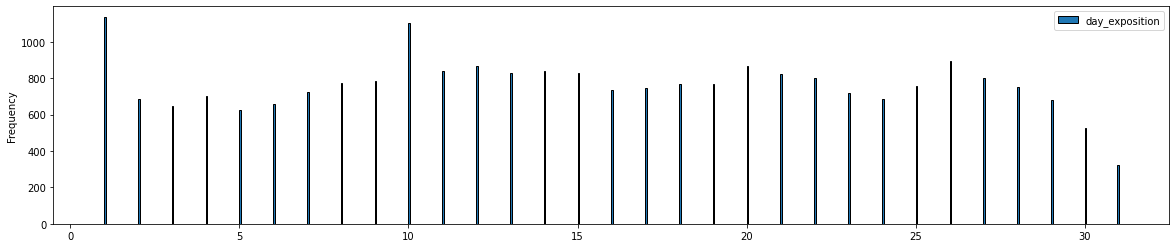

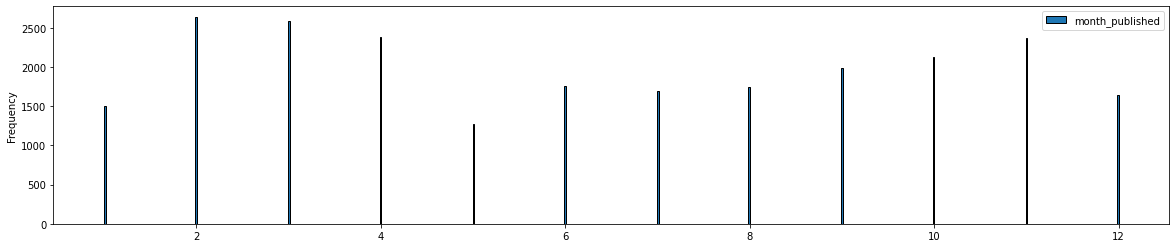

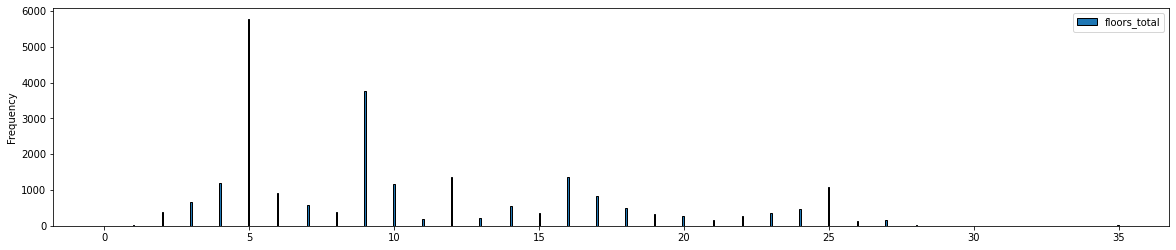

In [48]:
for column in columns:
    if column == 'last_price':
        data.plot(y=column, kind = 'hist', figsize = (20,4), bins = 600, edgecolor='black', logx=True)
    else:
        if column == 'type_floor':
            data['type_floor'].value_counts().plot(kind = 'bar', figsize = (20,4), edgecolor='black')
        else:
            data.plot(y=column, kind = 'hist', figsize = (20,4), range = (data[column].min(), data[column].quantile(0.99)), bins = 600, edgecolor='black')
data.plot(y='floors_total', kind = 'hist', figsize = (20,4), range = (0, 35), bins = 600, edgecolor='black');

In [49]:
data[columns].describe()

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floor,floors_total,cityCenters_nearest,airports_nearest,parks_nearest,day_exposition,month_published
count,23699.00,23699.00,23502.00,23699.00,23699.00,23699.00,23699.00,23613.00,18313.00,18312.00,17701.00,23699.00,23699.00
mean,60.35,34.45,10.59,6541548.77,2.08,2.70,5.89,10.67,14228.33,28869.51,494.68,15.48,6.40
std,35.65,21.80,5.65,10887013.27,1.07,0.24,4.89,6.60,8624.86,12669.23,229.29,8.64,3.49
min,12.00,8.30,5.00,12190.00,1.00,2.00,1.00,1.00,181.00,6450.00,27.00,1.00,1.00
25%,40.00,18.40,7.40,3400000.00,1.00,2.60,2.00,5.00,9274.00,18641.00,454.00,8.00,3.00
50%,52.00,30.30,9.55,4650000.00,2.00,2.65,4.00,9.00,13095.00,26833.50,498.60,15.00,6.00
75%,69.90,42.70,11.60,6800000.00,3.00,2.70,8.00,16.00,16319.00,37313.00,498.60,23.00,10.00
max,900.00,409.70,112.00,763000000.00,19.00,10.30,33.00,60.00,65968.00,84869.00,3190.00,31.00,12.00


Из гистограм распределений матрик можно сказать о том что:
- общая площадь 
    - подавляющее большинство представленных обьектов не более 100 метров, 
    - резкий спад числа обьектов начинается с площадей 60-70 метров, 
    - распределение имеет локальный максимум в районе 25 метров
- жилая площадь
    - распределение имеет 2 моды в окресности 18 метров и 30. 
    - Локальный максимум в окрестностях 18 является отражением локального максимума общей площади в окрестности 25 метров
- площадь кухни;
    - у распределения сильно выраженная дискретность (мало промежуточных значений между целыми значениями площадей)
    - Подавляющее число обьектов имеет кухню не более 20 метров
- цена объекта;
    - Подавляющее большинство цен распределено между 10^6 и 10^7
    - метрика имеет очень длинный хвост выбросов
- количество комнат
    - обьекты с 1, 2 комнатами распределены примерно одинаково
    - подавлющее большинство обьектов имеют  1, 2, 3 комнаты 
- высота потолков;
    - распределение имеет ярко выраженный максимум в 2.65
    - практически все значения выборки распределены в промежутке до 3 метров
- этаж квартиры
    - ярко выражены границы групп 5 и 9, 16 этажных домов, число продаваемых обьектов в которых примерно одинаково распределено по этажам
    - распределение равномерно убывает на всем обьеме значений
- тип этажа квартиры («первый», «последний», «другой»);
    - Число квартир на первом и последнем этаже примерно одинаково
    - наибольшее число квартир находятся ни на первом ни на последнем этаже
- общее количество этажей в доме;
    - ярко выражены локальные экстремумы в 5, 9, 10, 12, 16, 25 этажах
- расстояние до центра города в метрах;
    - Ярко выражены 3 группы
            - Обьекты находящиеся до 10км до центра города (с максимум в окрестности 5км) - небольшие города
            - обьекты находящиеся на расстоянии 10-20км до центра города - города миллионники
            - обьекты в 20+ км от центра города
- расстояние до ближайшего аэропорта;
     - присутствую в выборке подозрительно обособленные обьекты с расстоянием до аэропорта до 10км
     - - расстояние до аэропорта примерно равномерно распределено между 10км и 40км
- расстояние до ближайшего парка;
    - Подавляющее большинство знвчений равняется 498.60 
- день и месяц публикации объявления.
    - обьявления выкладываются практически равномерно во все дни месяца
    - дни в которые чаще всего выкладывали обявления 1 и 10, 30+31 (последний день месяца)
    - чаще всего обьявления выкладываются в феврале, марте, апреле и ноябре
    - реже всего обьявления выкладывались в январе и мае 

# 4.2 Распределение скорости продажи (days_exposition)

<AxesSubplot:ylabel='Frequency'>

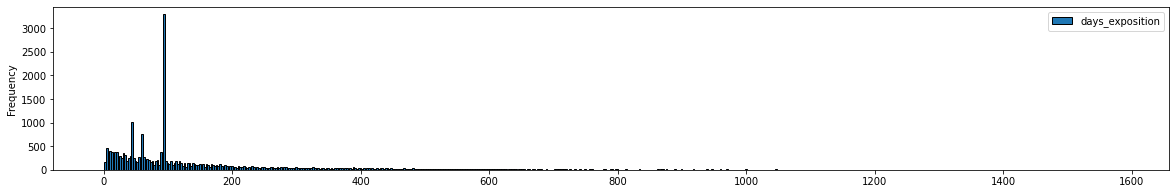

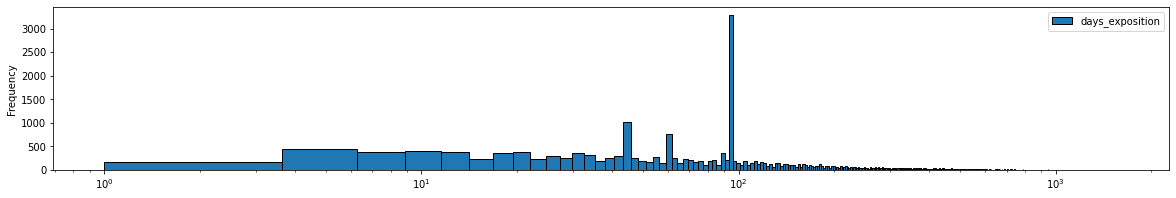

In [50]:
data.plot(y='days_exposition', kind = 'hist', figsize = (20,3), bins = 600, edgecolor='black')
data.plot(y='days_exposition', kind = 'hist', figsize = (20,3), bins = 600, edgecolor='black', logx=True)

<AxesSubplot:xlabel='days_exposition', ylabel='Proportion'>

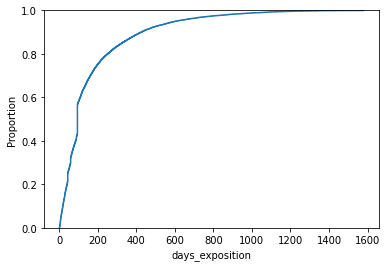

In [51]:
import seaborn as sns
sns.ecdfplot(data=data, x="days_exposition")

In [52]:
data['days_exposition'].describe()

count   23699.00
mean      169.36
std       206.54
min         1.00
25%        45.00
50%        95.00
75%       199.00
max      1580.00
Name: days_exposition, dtype: float64

In [53]:
data['days_exposition'].value_counts()

95      3245
45       880
60       538
7        234
30       208
        ... 
1572       1
1396       1
1268       1
1252       1
1391       1
Name: days_exposition, Length: 1141, dtype: Int64

#### Обьекты продаются в среднем за 169 дней (при медиане в 95). На среднее сильно влияет длинный хвост продаж, а на медиану сильно влияет занимающее 13% выборки значение в 95 дней (автозакрытие обьявлений?)

- Необычно долгими продажами можно назвать продажи за более чем 300 дней (больше 80 пройентиля выборки)
- Сложно выделить необычно быстрые продажи так как доля продаж по дням вплоть до 95 дня растет практически линейно

Какие факторы больше всего влияют на общую (полную) стоимость объекта?
 Изучите, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

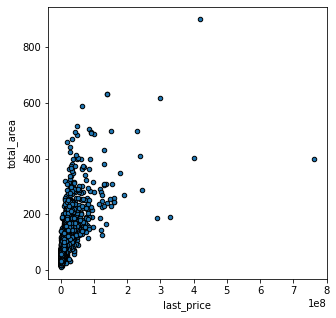

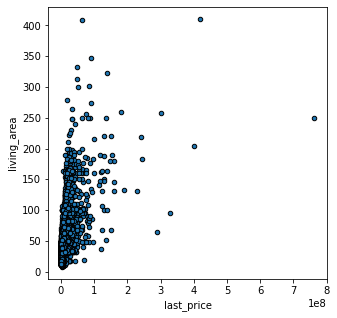

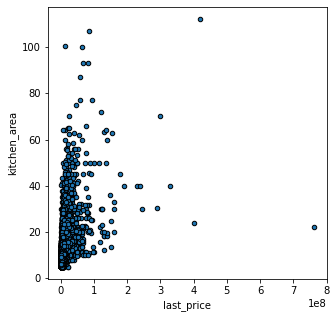

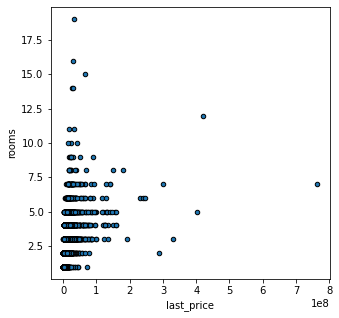

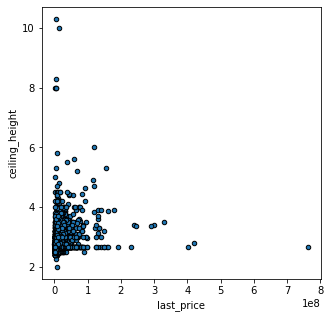

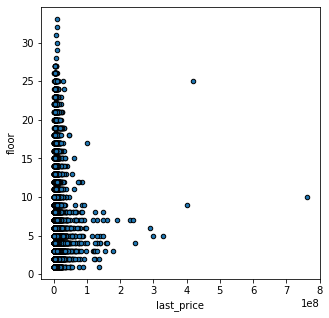

In [54]:
columns= ['total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height', 'floor']
for column in columns:
    data.plot(x='last_price', y=column, kind = 'scatter', figsize = (5,5), edgecolor='black')

In [55]:
corr_matrix = data.corr()
corr_matrix['last_price'].to_frame().sort_values(by = 'last_price', ascending=False).style.background_gradient(cmap='coolwarm')

,last_price
last_price,1.000000
total_area,0.653675
one_square_meter,0.627738
living_area,0.556981
kitchen_area,0.457902
rooms,0.365209
ceiling_height,0.268645
ponds_around3000,0.208621
balcony,0.208621
parks_around3000,0.197840


Наибольшая взаимосвязь между стоимостью и общей площадью, одним квадратным метром, жилой и кухонной площадью. Это видно по матрице кореляций и по графикам попарного распределения

##  Связь между типом этажа и стоимостью

In [56]:
data['last_price_log'] = np.log(data['last_price'])

<AxesSubplot:xlabel='last_price_log', ylabel='Density'>

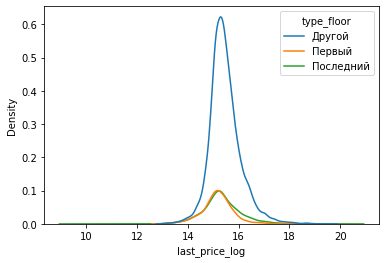

In [57]:
sns.kdeplot(data=data, x="last_price_log", hue='type_floor')

<AxesSubplot:xlabel='last_price_log', ylabel='Proportion'>

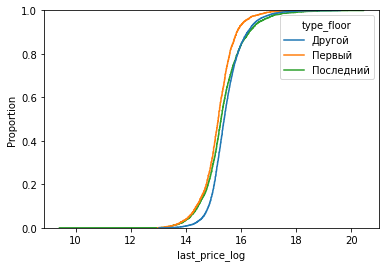

In [58]:
sns.ecdfplot(data=data, x = 'last_price_log', hue='type_floor')

<AxesSubplot:xlabel='type_floor'>

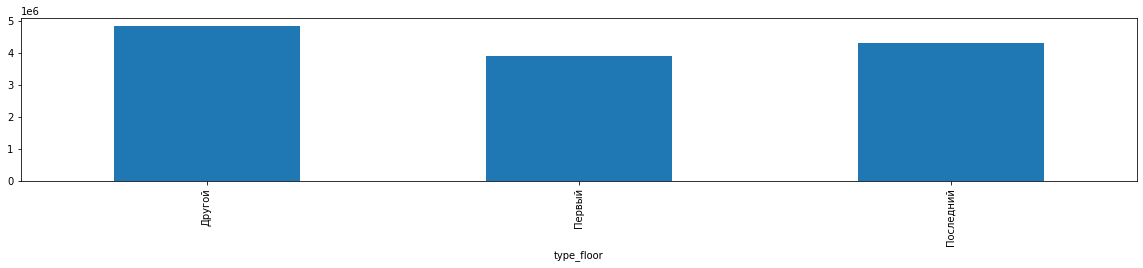

In [59]:
data.groupby('type_floor')['last_price'].describe()['50%'].plot(y='days_exposition', figsize = (20,3), kind='bar')

In [60]:
data.groupby('type_floor')['last_price'].describe()

,count,mean,std,min,25%,50%,75%,max
type_floor,,,,,,,,
Другой,17363.00,6674074.18,8623312.48,450000.00,3600000.00,4850000.00,7000000.00,330000000.00
Первый,2914.00,4805699.09,5100972.27,430000.00,2800000.00,3900000.00,5400000.00,135000000.00
Последний,3336.00,7361024.84,20692959.80,12190.00,3000000.00,4300000.00,6700000.00,763000000.00


Судя по всему стоимость обьекта все же несколько выше на промежуточном этаже (хоть у последних этажей среднее стоимостей выше, но медиана и даже 75процентиль у обьектов на промежуточных этажах выше, график распределений стоимостей обьектов на промежуточных этажах так же смещен правее относительно обьектов на первом или последнем этаже)

## Оценка взаимосвязи стоимости обьекта с днем недели/месяцем/годом

In [61]:
# Добавим день недели, и год
data['weekday_exposition'] = data['first_day_exposition'].apply(lambda x: x.strftime('%A'))
data['month_exposition'] = data['first_day_exposition'].apply(lambda x: x.strftime('%B'))
data['year_exposition'] = data['first_day_exposition'].apply(lambda x: x.strftime('%Y'))

In [62]:
data.groupby('weekday_exposition')['last_price'].describe()[['count','mean','50%']].style.background_gradient(cmap='RdYlGn')

,count,mean,50%
weekday_exposition,,,
Friday,4000.000000,6372130.603750,4585000.000000
Monday,3612.000000,6511613.423588,4650000.000000
Saturday,1936.000000,6976803.942665,4555000.000000
Sunday,1699.000000,6246180.297822,4550000.000000
Thursday,4295.000000,6708663.231665,4650000.000000
Tuesday,4183.000000,6394233.422424,4730000.000000
Wednesday,3974.000000,6627970.430549,4700000.000000


In [63]:
data.groupby('month_exposition')['last_price'].describe()[['count','mean','50%']].style.background_gradient(cmap='RdYlGn')

,count,mean,50%
month_exposition,,,
April,2379.000000,6737198.467844,4800000.000000
August,1744.000000,6350232.973624,4570000.000000
December,1641.000000,7011731.432663,4700000.000000
February,2640.000000,6468500.107197,4650000.000000
January,1500.000000,6668233.125333,4600000.000000
July,1695.000000,6649337.485546,4650000.000000
June,1760.000000,6310269.395455,4400000.000000
March,2587.000000,6359275.465017,4650000.000000
May,1274.000000,6600435.248823,4515000.000000


In [64]:
data.groupby('year_exposition')['last_price'].describe()[['count','mean','50%']].style.background_gradient(cmap='RdYlGn')

,count,mean,50%
year_exposition,,,
2014,137.000000,12087135.941606,7700000.000000
2015,1191.000000,8572833.299748,5350000.000000
2016,2783.000000,6827912.194754,4550000.000000
2017,8190.000000,6585729.349328,4500000.000000
2018,8519.000000,5950966.434441,4550000.000000
2019,2879.000000,6782388.394929,5050000.000000


In [65]:
data.groupby('weekday_exposition')['last_price'].describe()

,count,mean,std,min,25%,50%,75%,max
weekday_exposition,,,,,,,,
Friday,4000.00,6372130.60,8536777.99,450000.00,3440000.00,4585000.00,6700000.00,190870000.00
Monday,3612.00,6511613.42,9631997.18,430000.00,3450000.00,4650000.00,6700000.00,300000000.00
Saturday,1936.00,6976803.94,21645150.45,550000.00,3372500.00,4555000.00,6600000.00,763000000.00
Sunday,1699.00,6246180.30,7895173.33,470000.00,3400000.00,4550000.00,6500000.00,130000000.00
Thursday,4295.00,6708663.23,8469948.61,450000.00,3450000.00,4650000.00,6985000.00,159984000.00
Tuesday,4183.00,6394233.42,8602253.22,430000.00,3440000.00,4730000.00,6800000.00,289238400.00
Wednesday,3974.00,6627970.43,11782986.98,12190.00,3429000.00,4700000.00,6900000.00,420000000.00


In [66]:
sns.set(rc={'figure.figsize':(15,10)})

<AxesSubplot:xlabel='last_price_log', ylabel='Density'>

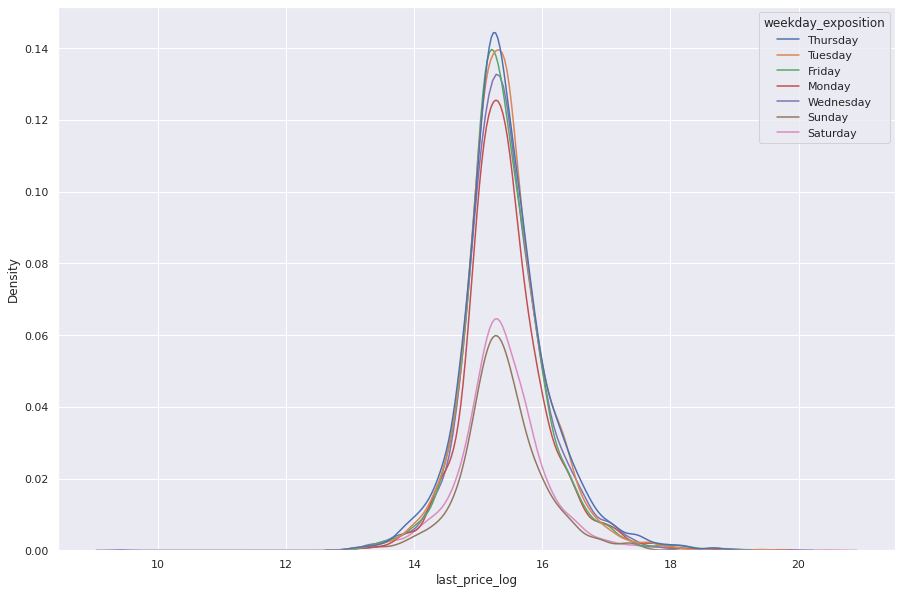

In [67]:
sns.kdeplot(data=data, x="last_price_log", hue='weekday_exposition', fill=False)

<AxesSubplot:xlabel='last_price_log', ylabel='Proportion'>

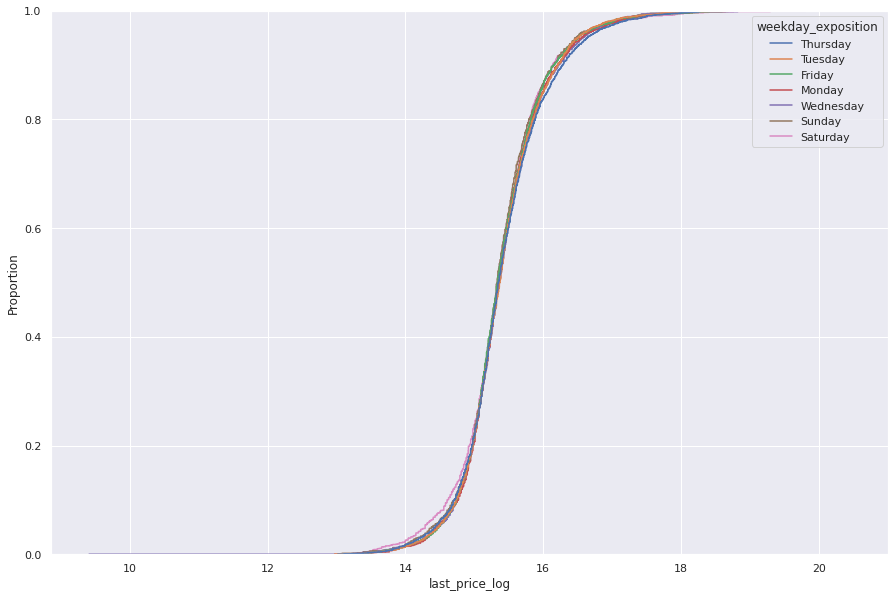

In [68]:
sns.ecdfplot(data=data, x = 'last_price_log', hue='weekday_exposition')

<AxesSubplot:xlabel='last_price_log', ylabel='Density'>

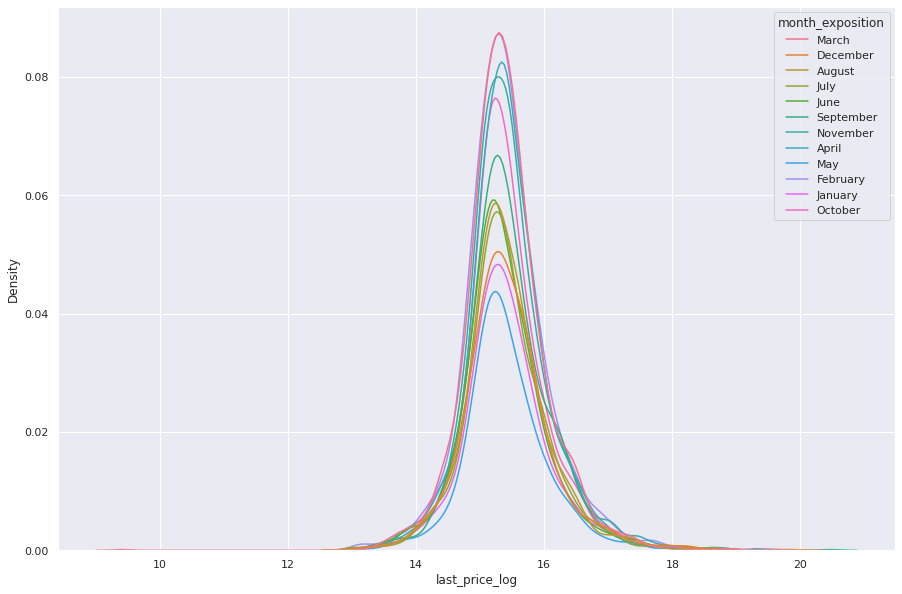

In [69]:
sns.kdeplot(data=data, x="last_price_log", hue='month_exposition', fill=False)

<AxesSubplot:xlabel='last_price_log', ylabel='Proportion'>

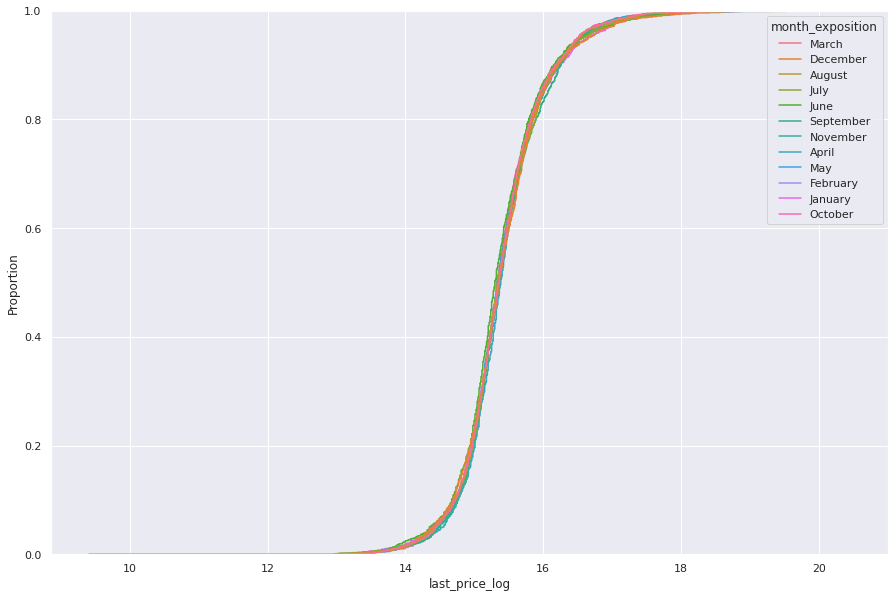

In [70]:
sns.ecdfplot(data=data, x = 'last_price_log', hue='month_exposition')

<AxesSubplot:xlabel='last_price_log', ylabel='Density'>

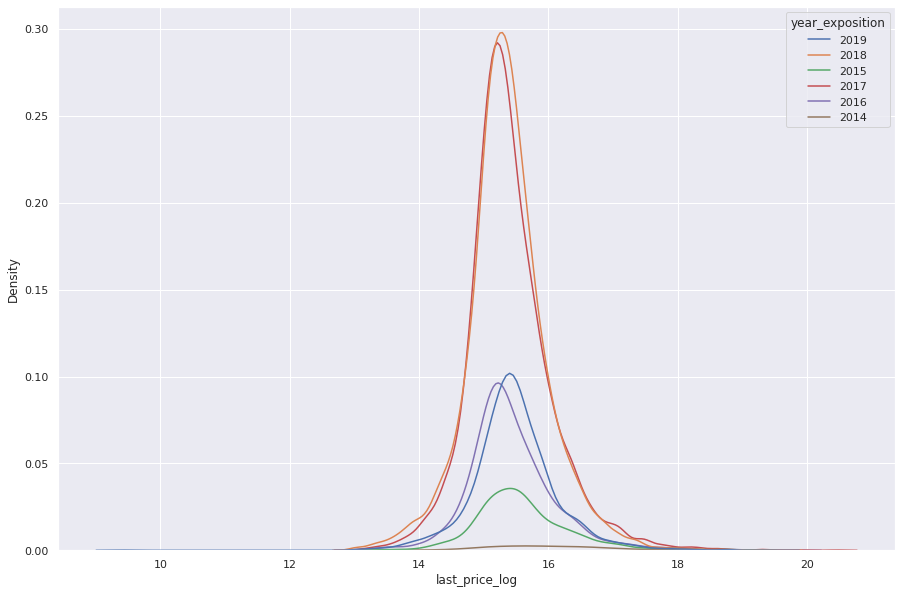

In [71]:
sns.kdeplot(data=data, x="last_price_log", hue='year_exposition', fill=False)

<AxesSubplot:xlabel='last_price_log', ylabel='Proportion'>

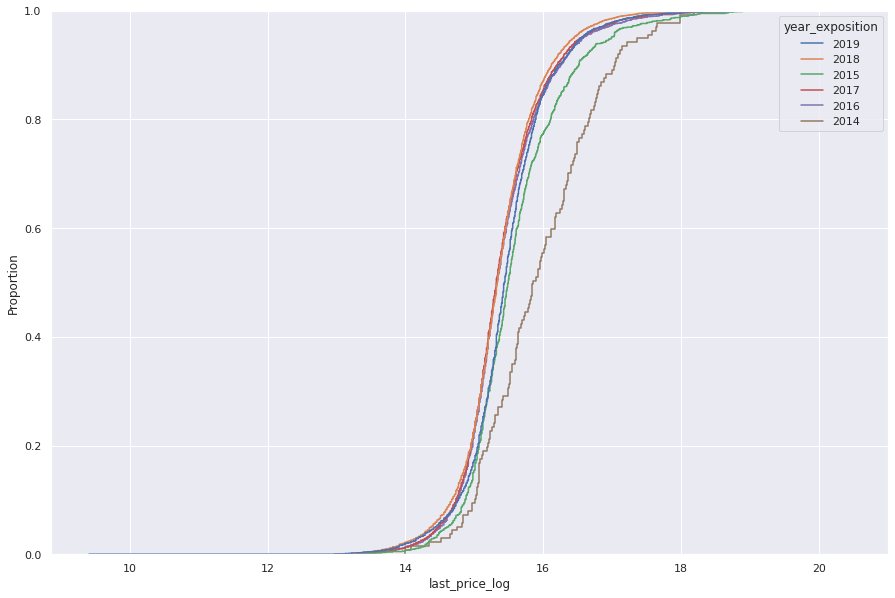

In [72]:
sns.ecdfplot(data=data, x = 'last_price_log', hue='year_exposition')

Сложно выявить какую-то прямую зависимость между днем/месяцем/годом и стоимостью
   - судя по всему стоимость обектов в конце весны-летом в среднем несколько ниже

# 4.4 Оценка средней стоимости квадратного метра

In [73]:
data['cost_of_one_square_meter'] = data['last_price']/data['total_area']

In [74]:
grouped_meter_cost = data.groupby('locality_name')['cost_of_one_square_meter'].mean().to_frame()

In [75]:
top_10 = data['locality_name'].value_counts().to_frame()[:10]
top_10['cost_of_one_square_meter'] = grouped_meter_cost['cost_of_one_square_meter']

In [76]:
top_10.sort_values(by='cost_of_one_square_meter')

,locality_name,cost_of_one_square_meter
выборг,237,58141.91
всеволожск,398,68654.47
гатчина,307,68746.15
колпино,338,75424.58
шушары,440,78677.36
мурино,590,86087.51
парголово,327,90175.91
кудрово,472,95324.93
пушкин,369,103125.82
санкт-петербург,15721,114849.01


Таким образом, самая высокая стоимость одного квадратного метра в санкт-петербурге (114849.01), а самая низка в выборге (58141.91)

In [77]:
data.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
санкт-петербург,15721,5500000.00
мурино,590,3400000.00
кудрово,472,3890000.00
шушары,440,3950000.00
всеволожск,398,3450000.00
пушкин,369,5180000.00
колпино,338,3600000.00
парголово,327,4100000.00
гатчина,307,3100000.00


# 4.5 Оценка стоимости одного километра

In [78]:
data['distance_price'] = data['last_price']/data['distance_in_km']
distance_price_by_km = data[data['locality_name']=='санкт-петербург'].groupby('distance_in_km')['distance_price'].mean()

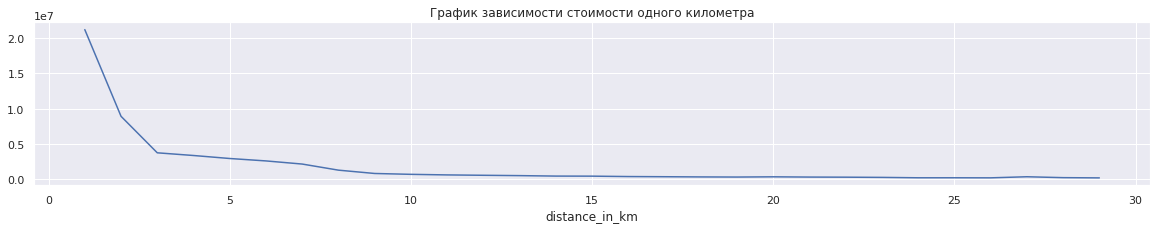

In [79]:
distance_price_by_km.plot( figsize = (20,3), title = 'График зависимости стоимости одного километра');

На графике очень хорошо виден характер зависимости: средняя стоимость обьекта зависит обратно логарифмически от расстояния до центра города

# Вывод

В процессе изучения датафрейма было выделено большое количество пропусков. В целях предотвращения утери большого количества данных (а именно удаление строк, где пропуски имелись), были предприняты поиски значений, которыми можно было заполнить отсутствие информации, не навредив общей картине, чтобы не помелись выводы после проделанной работы. Однако не во всех колонках замены удалось найти, однако подавляющее большинство удалость устранить заменой (а именно в колонках с информацией о расстоянии до ближайшего аэропорта, водоема, парка и центра города, поскольку в большинстве случаев информации по населенным пунктам не было и выбранный единственный рабочий метод поиска среднего по населенным пунктам не сработал во всех случаях), тем самым перейдя к следующему этапу обработки данных - поиски дубликатов. В процессе поисков было выявлено, что явных дубликатов не было найдено, и были предприняты попытки поиска неявных именно в колонке с инфомарцией о населенном пункте (потому что эта колонка была самым логичным выбором для поиска неявных дубликатов). В процессе устранения неявных дубликатов были предприняты попытки устранения заглавных букв, замены буквы "Ё" на "Е", а также удалены обозначения чем конкретно населенный пункт является. Проделанная работа поможет в будущем при исследовании получить более общую картину по населенным пунктам. После устранения аномалий и построения графиков, изучая их в различных разрезах, были сделаны выводы, что на стоимость квартиры влияют такие факторы как местоположение, площадь (общая. жилая и кухни), расстояние от центра города, а также этаж, на котором расположена квартира. Также было выявлена что самой дорогой недвижимостью (в датафрейме) являются квартиры в Санкт-Петербурге стоимостью 114849.01 на квадратный метр